# 0 - Abstract - Introduction

This notebook is influenced by [Rossman Store Sales competition](https://www.kaggle.com/competitions/rossmann-store-sales) that held in Kaggle and ran from 30th of September to 12th of December, 2015. The aim of the competition was to forecast the sales for individual stores of (almost) 7 weeks interval between 01.08.2015-17.09.2015. Rossmann provided a training data set consistent of daily sales data of 1115 stores located in Germany from 01.01.2013 to 31.07.2015 and data on competitors for supplement.

I am going to apply my current knowledge on this data set and I am planning to update it as my knowledge on the field.

The data set is obtained from [Kaggle](https://www.kaggle.com/competitions/rossmann-store-sales/data)\
Most of the data fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1 - Loading Libraries and Data Set

In [86]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore') # warnings in loading the data set, seasonal plots, and perodograms

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data celaning
from sklearn.preprocessing import LabelEncoder

# Feature engineering
from statsmodels.tsa.deterministic import (DeterministicProcess,
                                           CalendarFourier)

# Modeling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
                                     # ( , cross_val_score, GridSearchCV, KFold, StratifiedKFold, learning_curve, validation_curve)

from sklearn.metrics import mean_squared_error

print("It is good to go, lift off chief.")

It is good to go, lift off chief.


In [87]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 10),
    # titlesize=18,
    # titleweight='bold',
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

The data set is consistent of three individual files, lets, check the differences between them.

In [88]:
import ipywidgets as widgets

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

store = pd.read_csv('Data\store.csv')
train = pd.read_csv('Data/train.csv') # `\t` part works as a/an 'tab/indent' so this generated a data loading problem. Use '\\' or '/t' instead of '\t'
test = pd.read_csv('Data/test.csv')

datasets = [store, train, test]

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])

for i, df in enumerate(datasets):
    data_tabs.set_title(i, get_df_name(datasets[i]))
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

Only `'train.csv'` file includes sales variable and `'store.csv'` file is included to support the analysis i.e. to determine if there is seasonality and it's effect on sales.

A warning message appears, which tells us that `'StateHoliday'` column in `'train.csv'` file is consist of multiple data types, as seen below there are two types of `'0'`'s, one is `string` and the other is `integer` type. I should better deal with this in data cleaning phase.

In [4]:
display(train['StateHoliday'].unique())
train['StateHoliday'].unique()[4] == train['StateHoliday'].unique()[0]

array(['0', 'a', 'b', 'c', 0], dtype=object)

False

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# train.Date.describe()
train['Date'].describe()

count        1017209
unique           942
top       2015-07-31
freq            1115
Name: Date, dtype: object

In [7]:
print(train.Date.describe()[1],'days of data')

942 days of data


I can use the content of `'train.csv'` file to work, since there are enough observations to forecast.

In [8]:
train['Date'].head()

0    2015-07-31
1    2015-07-31
2    2015-07-31
3    2015-07-31
4    2015-07-31
Name: Date, dtype: object

In [9]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

No missing values, good, one thing less to deal with.

# 2 - Data Cleaning

## 2.1 - Converting data type of `'Date'` column to `datetime`


Because the dtype of `'Data'` column is `object` rather than `datetime64`, Python doesn't know that this column contains dates. It is better to convert content of the `'Date'` column's data type from `object` to `datetime64` or parse date format manually into a new column. Below this issue is handled by Pandas.

In [89]:
sales = pd.read_csv('Data/train.csv', 
                    parse_dates=['Date'],
                   )

sales['date_parsed'] = sales['Date'].copy()

# Line below is maual formatting 
# sales['date_parsed'] = pd.to_datetime(sales['Date'], format="%Y-%m-%d")

sales = sales.set_index('date_parsed').to_period('D')
sales = sales.sort_index()

sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
date_parsed,,,,,,,,,
2013-01-01,1115,2,2013-01-01,0,0,0,0,a,1
2013-01-01,379,2,2013-01-01,0,0,0,0,a,1
2013-01-01,378,2,2013-01-01,0,0,0,0,a,1
2013-01-01,377,2,2013-01-01,0,0,0,0,a,1
2013-01-01,376,2,2013-01-01,0,0,0,0,a,1


In [18]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1017209 entries, 2013-01-01 to 2015-07-31
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 77.6+ MB


In [19]:
# convert scientific notation to float since Pandas' default notation is scientific.
pd.options.display.float_format = '{:.2f}'.format

sales.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00


Since we are focusing on the total sales, it would be beneficial to limit our features just with sales for now.

In [90]:
total_sales = sales.set_index(['Store'], append=True)                         
total_sales = total_sales.groupby('Date').sum()['Sales'].to_frame()

total_sales.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


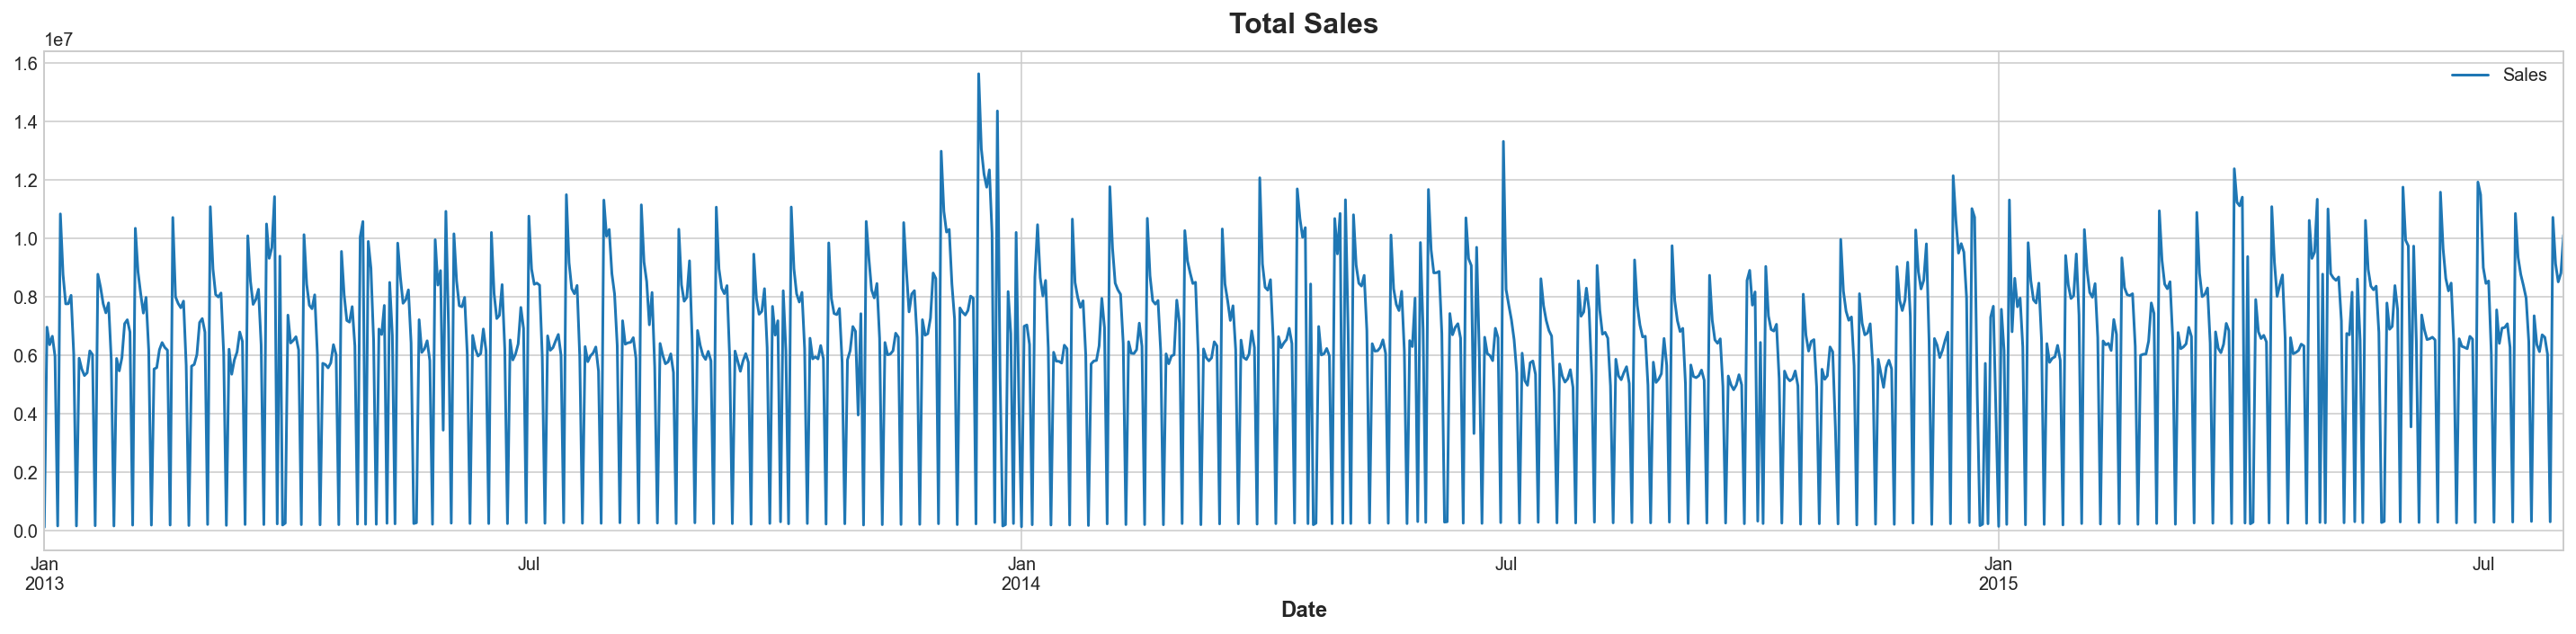

In [24]:
total_sales.plot(title="Total Sales", figsize = (20,5));

The picks in the graph implies existence of potential seasonality, we will address this issue in the following section.

# 3 - Investigating Time Dependence

Eyeballing on the `Total Sales` graph gives us a hint that there is a seasonality potential in our series.\
Hence, it is a good practice to check if there is a trend and/or seasonality in time series.

## 3.1 - Identifying and Determining the trend

### 3.1.1 - Identifying the trend by using `moving average` plot (eyeballing)

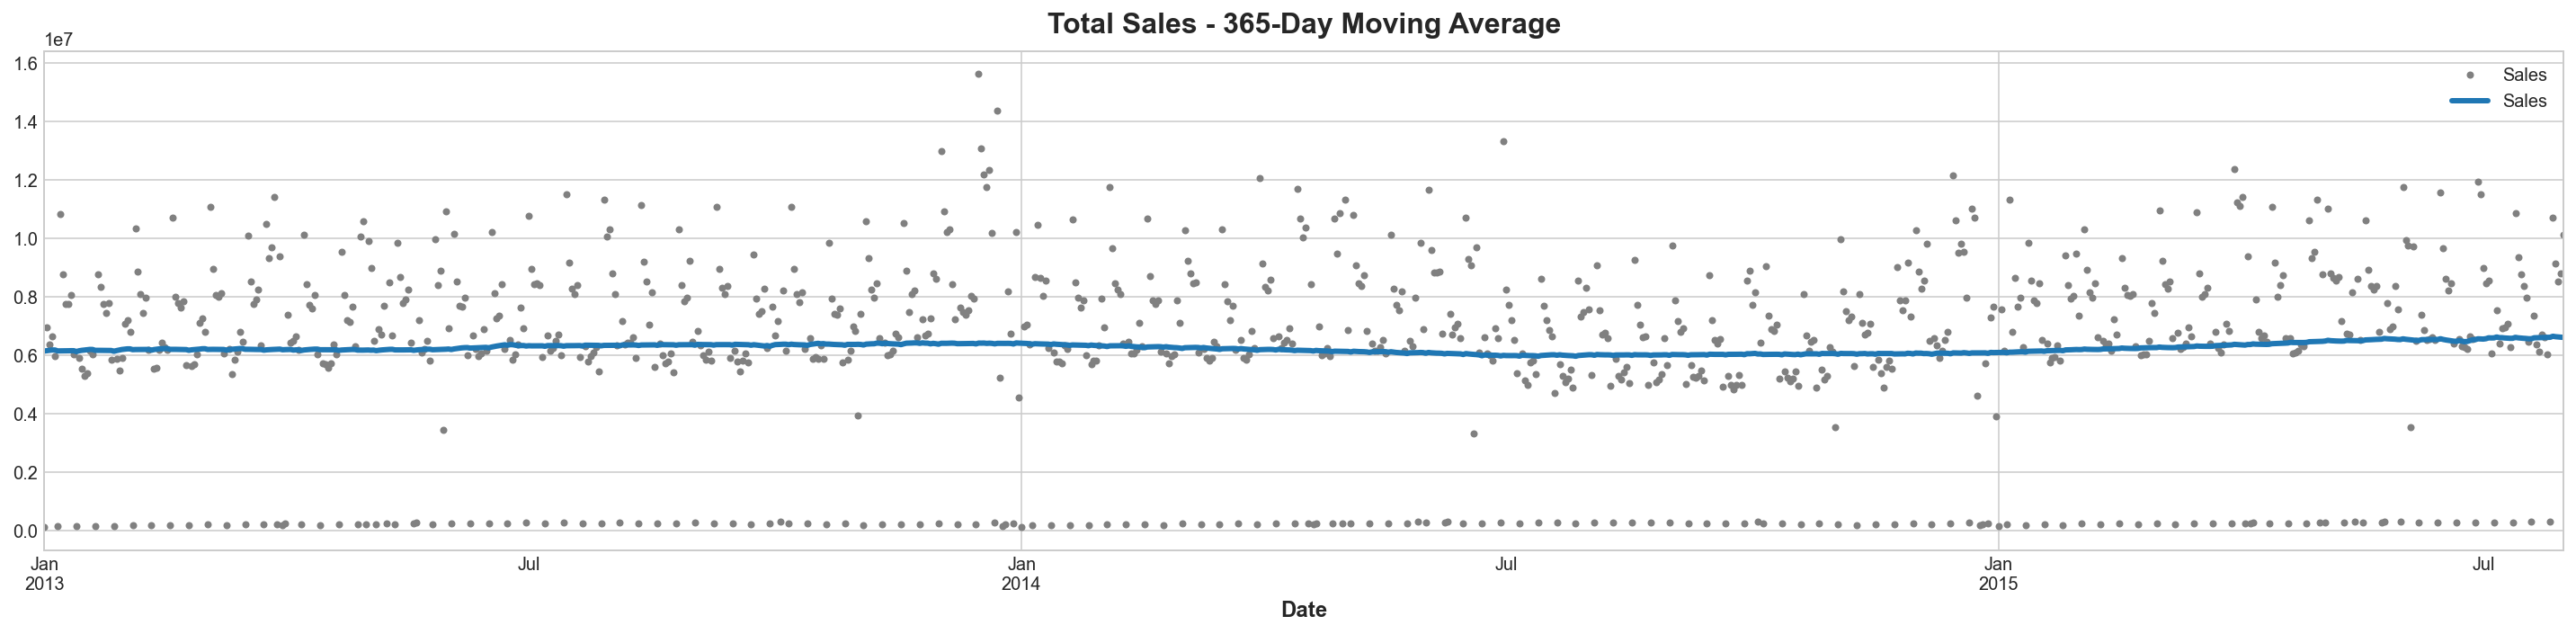

In [25]:
moving_average = total_sales.rolling(
    window=365,        # 365 day window
    center=True,       # puts the average at the center of the window
    min_periods=183,   # choose about half the window size
).mean()               # compute the mean (could also do median, std, min, max, ...)

ax = total_sales.plot(style=".", color="0.5")

moving_average.plot(
    ax=ax, linewidth=3, 
    title="Total Sales - 365-Day Moving Average", 
    figsize=(20,5),
    # legend=False,
)
ax.legend();

By eyeballing, it is hard to say if there is a trend. Let's try to determine the trend by using the linear regression approach.

### 3.1.2 - Determining the trend by using linear regression

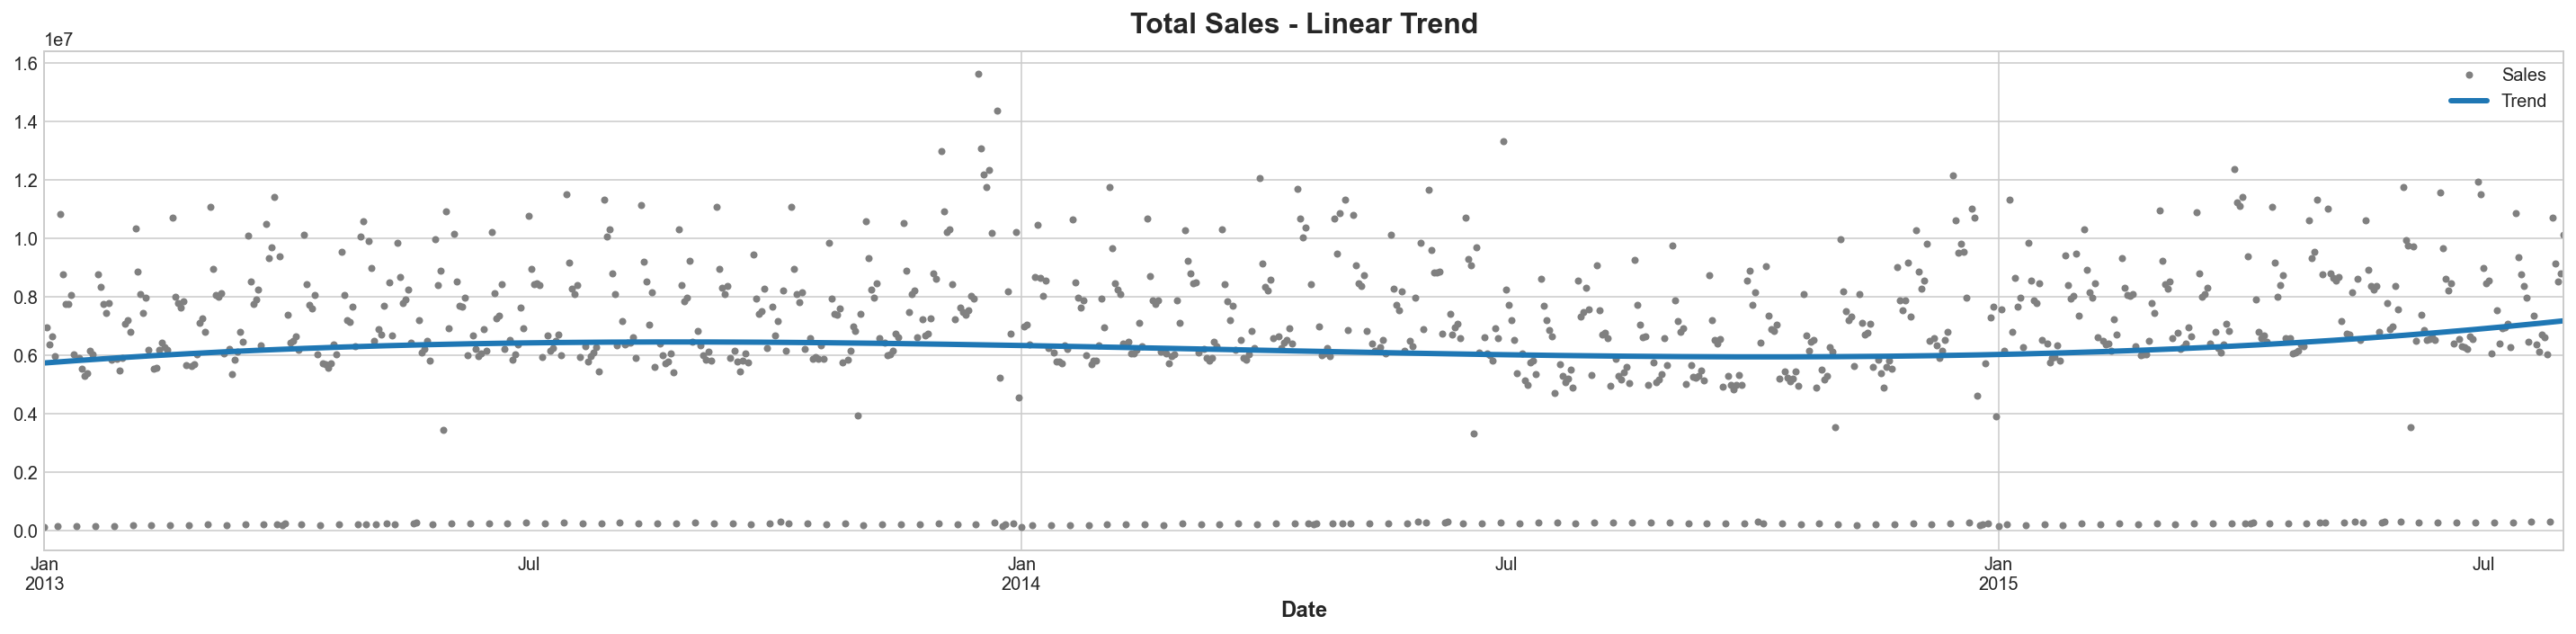

In [26]:
dp = DeterministicProcess(
    index=total_sales.index,  # dates from the training data
    constant=True,            # dummy feature for the bias (y_intercept)
    order=3,                  # the time dummy (trend)
    drop=True,                # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()
# X.head()

from sklearn.linear_model import LinearRegression

y = total_sales["Sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(
    model.predict(X), 
    index=X.index,
    name='Fitted',
)

ax = total_sales.plot(style=".", color="0.5", title="Total Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend", figsize = ((20,5)))
ax.legend();

Trend seems like rather stationary, barely a trend, and there are hints of polynomial relationship. I.e. with a third order `'trend'` variable, the trend curve looks similar to the moving average line.

## 3.2 - Checking The Seasonality

### 3.0 - Plotting functions

In [27]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    import seaborn as sns
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

### 3.1 - Seasonality plot (eyeballing)

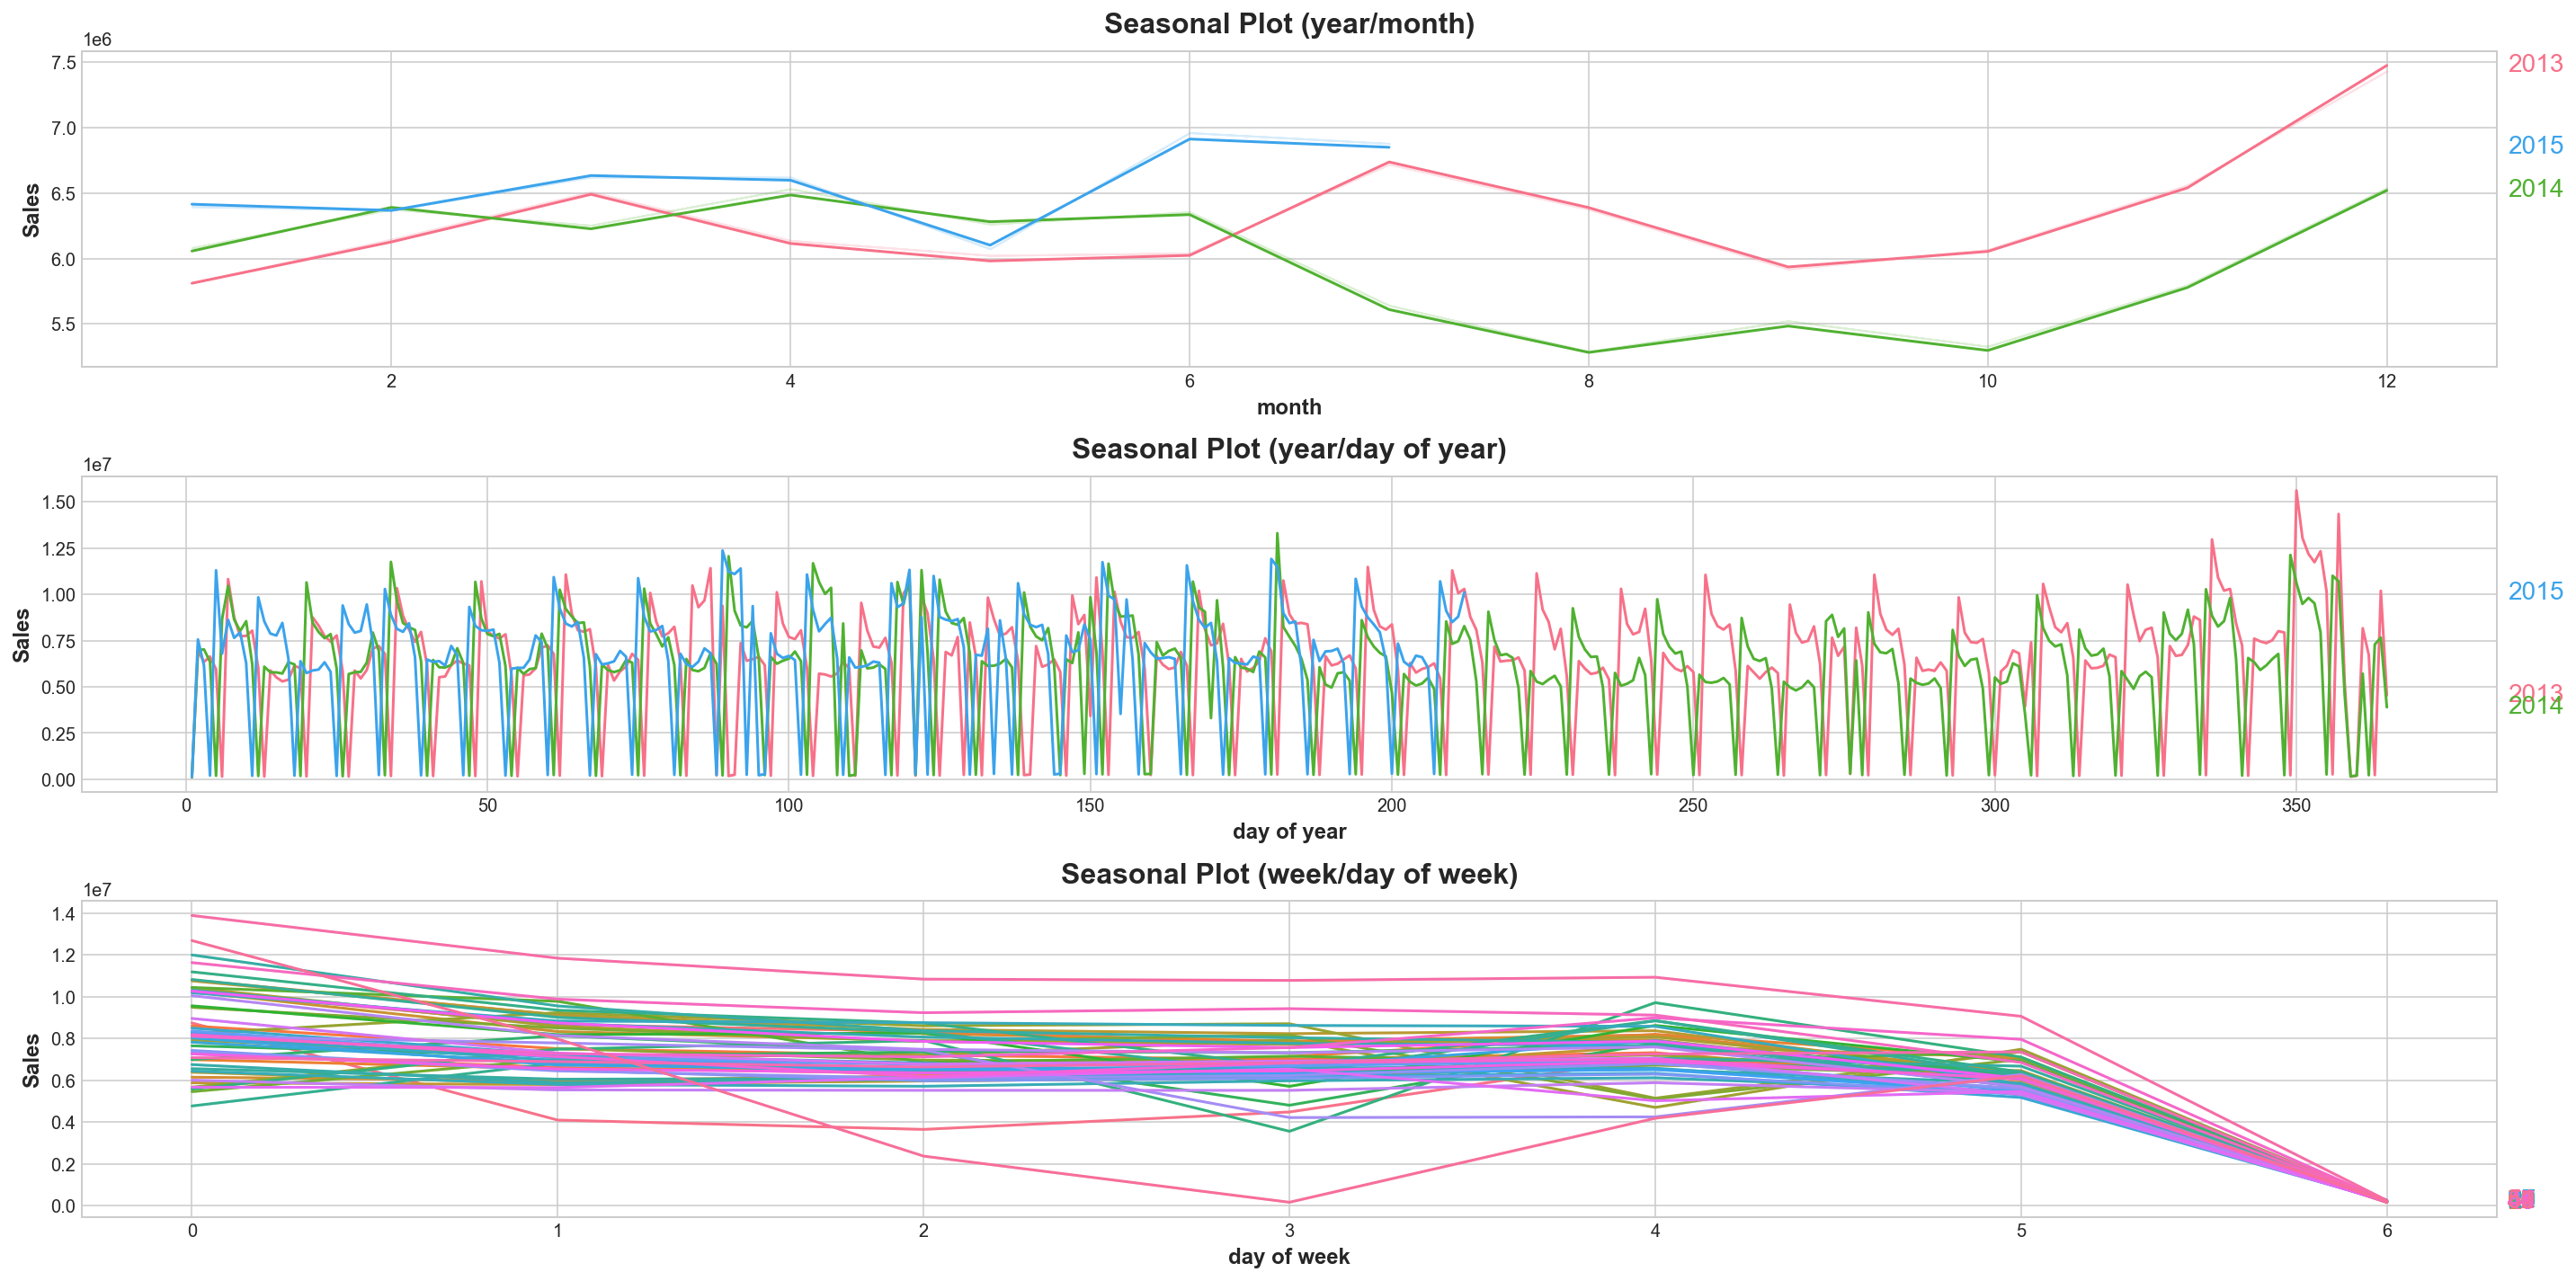

In [91]:
X = total_sales.copy()

# months within a year
X["month"] = X.index.month

X["week"] = X.index.week
X['day of week'] = X.index.dayofweek

# days within a year
X["day of year"] = X.index.dayofyear
X["year"] = X.index.year

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

seasonal_plot(X, y='Sales', period="year", freq='month', ax=ax1)
seasonal_plot(X, y='Sales', period="year", freq="day of year", ax=ax2)
seasonal_plot(X, y='Sales', period="week", freq="day of week", ax=ax3);

Eyeballing on the middle chart, `'Seasonal PLot (year/day of year)'`, indicates an additive seasonality with no trend, possibly a weekly or (due to the double spikes) a semi-weekly season. Demand within a week is particularly highest on mondays and fridays respectively, and lowest on sundays as seen on the bottom chart, `'Seasonal PLot (week/day of week)'`. 

Another interesting and reasonable finding is the demand on decembers, as seen on the top chart (`'Seasonal PLot (year/month)'`) the demand in decembers is the highest.

To determine the most useful sesonality period we should check the periodogram.

### 3.2 - Fourier Features and the Periodogram

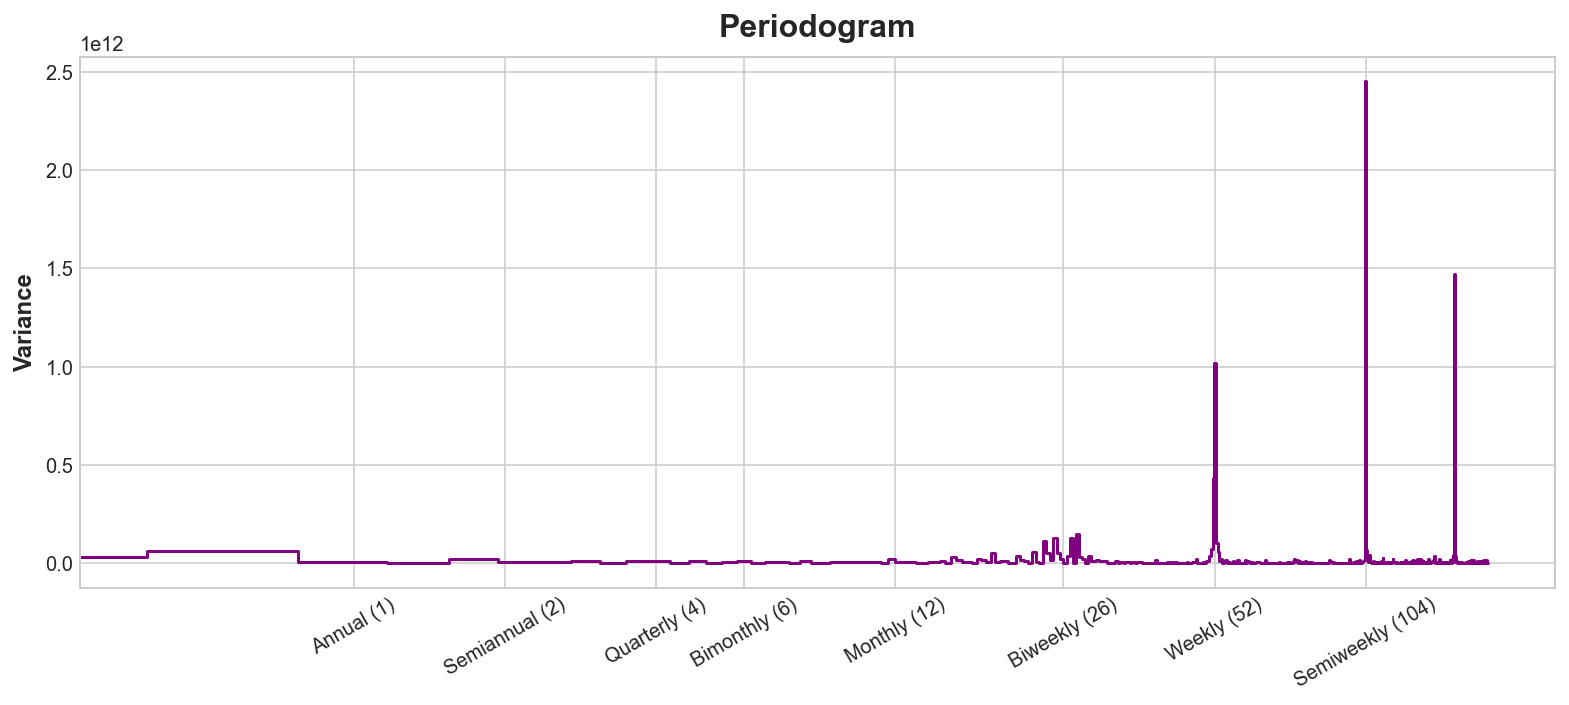

In [95]:
plt.rc("figure", autolayout=True, figsize=(11, 5))

plot_periodogram(total_sales.Sales);

Periodogram confirms the presence of seasonality in the series, which is weekly and semi-weekly season as expected. The evidence of a semi-weekly season is stronger than a weekly season.

In terms of business days in Germany this makes sense since vast majority of the shops are closed on sundays and people are tend to do shopping on the first day of the week and/or the day before weekend.

# 5 - Investigating Serial Dependence

In this section, we will check wether there is a serial dependence i.e. cycles in this series.

We will make use of `'lags'` since using lags of endogenous explanatory variables (as a new feature) help us to tackle `reverse causality`.

## 5.0 - Lag plotting functions

In [72]:
def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    import seaborn as sns
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax

## 5.1 - Detrending and deseasoning

To determine the cyclic behaviour, we will isolate the cyclic behaviour by deseasonalising the series since trend and seasonality will both create serial dependence.\
We will be able to capture the frequence of the seasonality by inspecting correlograms and lag plots.

In [96]:
fourier = CalendarFourier(freq='A', order=104) # Since weekly season is going to be held by 'DeterministicProcess()', 
                                               # we have to deal with bi-weekly season by using fourier features.
                                               # 'A'nnually 104 sin/cos pairs.

dp = DeterministicProcess(
    index=y.index,
    constant=True,   # dummy feature for bias (y-intercept)
    order=3,         # trend
    seasonal= True,  # weekly seasonality (seasonal indicators)
    drop=True,       # drop terms to avoid collinearity
    additional_terms=[fourier],
)
X = dp.in_sample()

y = total_sales["Sales"]  # the target, as in the section 3.1.2

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(
    model.predict(X), 
    index=X.index,
    name='Fitted',
)

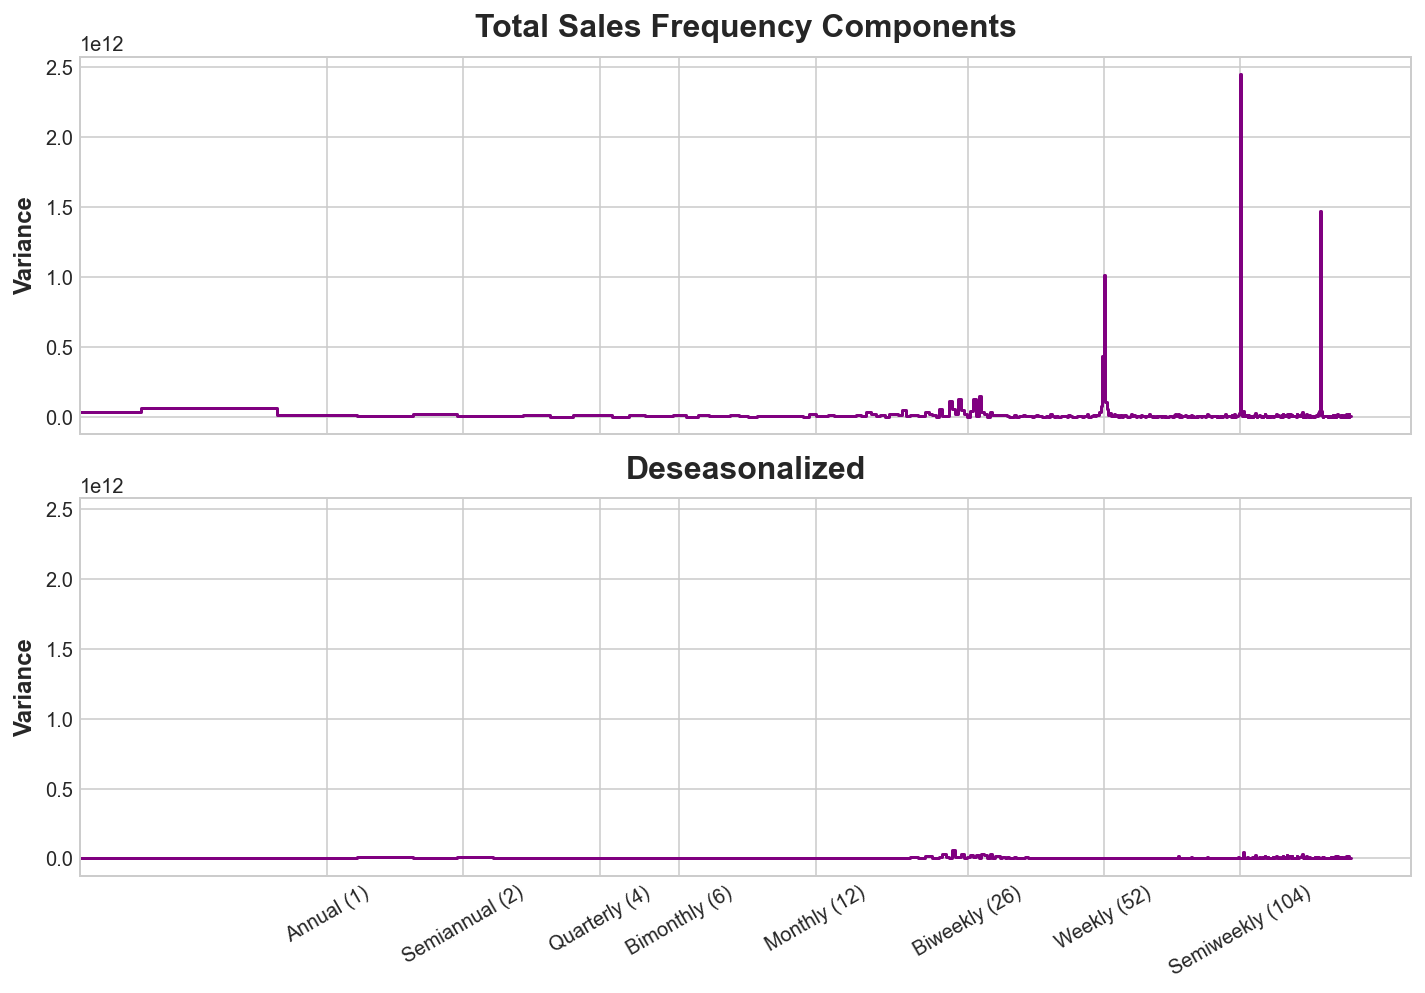

In [97]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Total Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

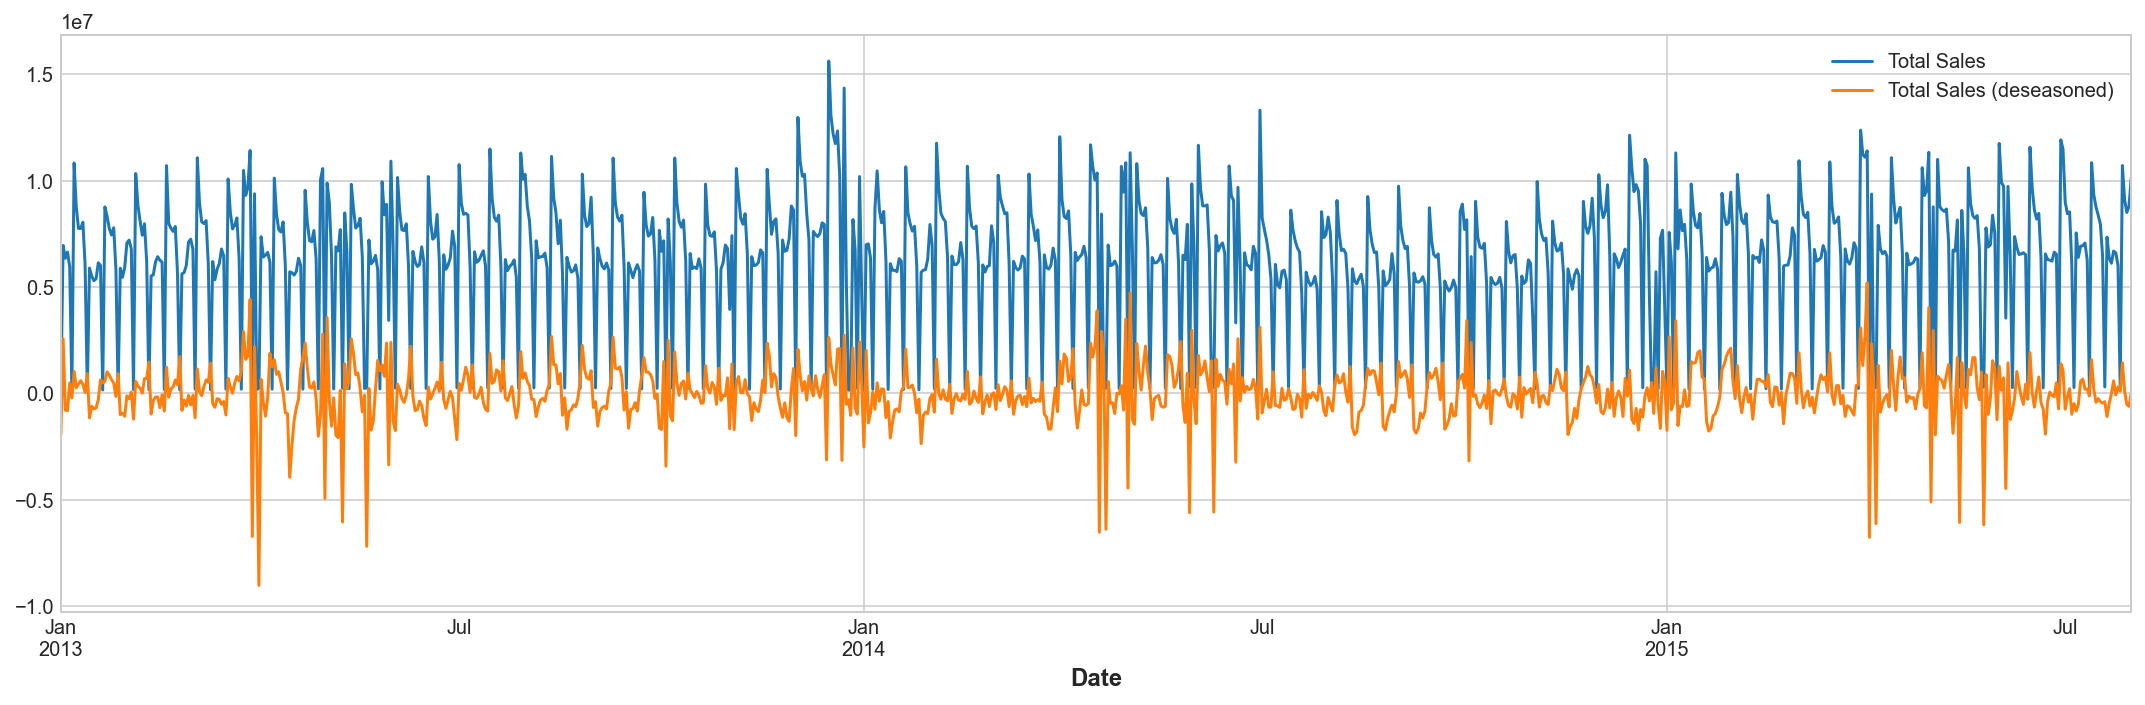

In [75]:
y.plot(legend=True, label='Total Sales',  figsize=(15, 5))
y_deseason.plot(legend=True, label='Total Sales (deseasoned)', figsize=(15, 5));

It looks like the series is somehow deseasonalized in terms of weekly seasonality, the remaining flactuation (orange line) is most likely originated from cyclic behavoiur or other seasonal effects such as national holidays or periodical promotions.
- Promotion details are given in the data set, it worths to check them.
- National holidays might differ from state to state i.e. southern states celebrates more religious holidays than northern states. An additional supportive data set of stores' location by state has been provided

**TODO!!**: create featrues as dates of 'promotions' and 'national holidays' by store.

## 5.2 - Identifying the cycles

Serial dependence in a time series will often become apparent by looking at a lag plot.

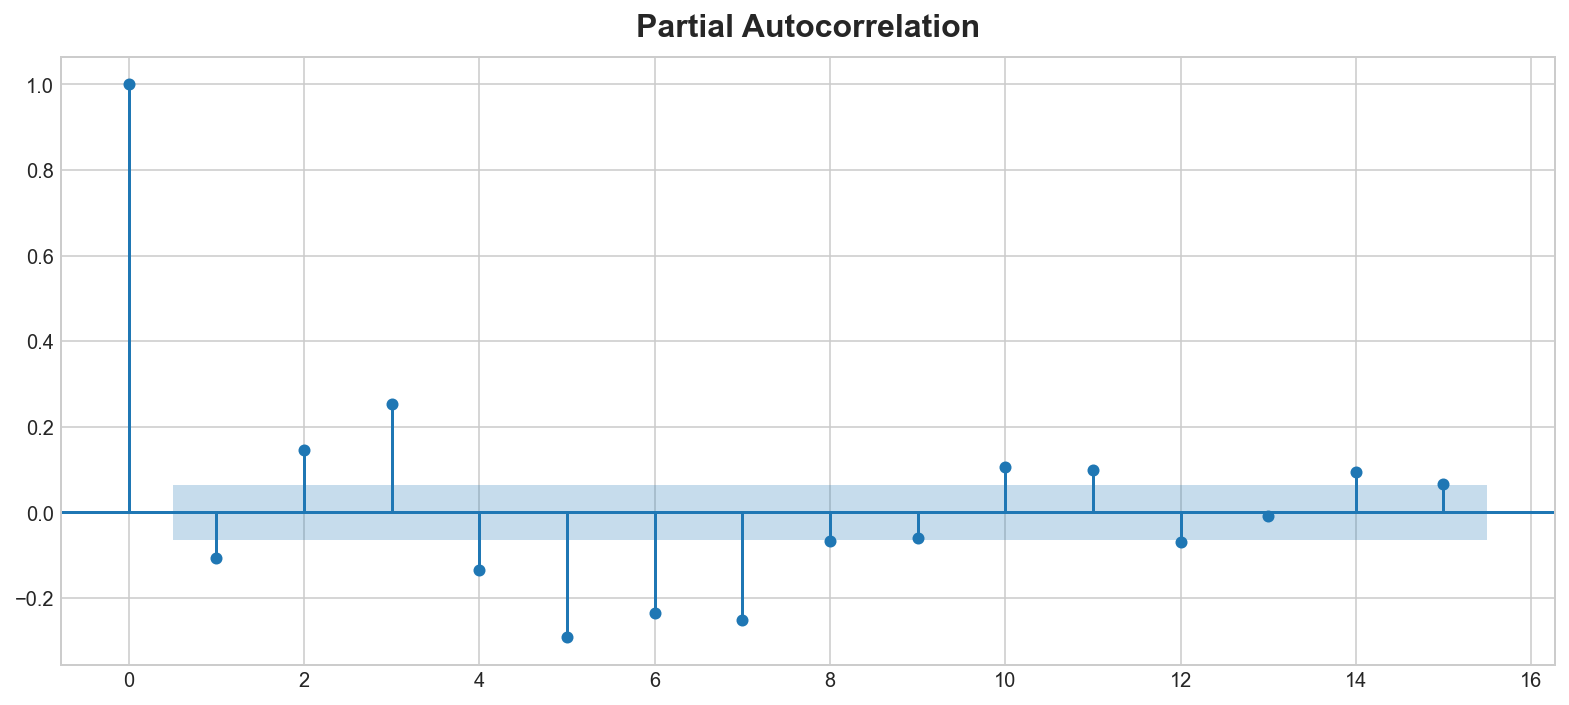

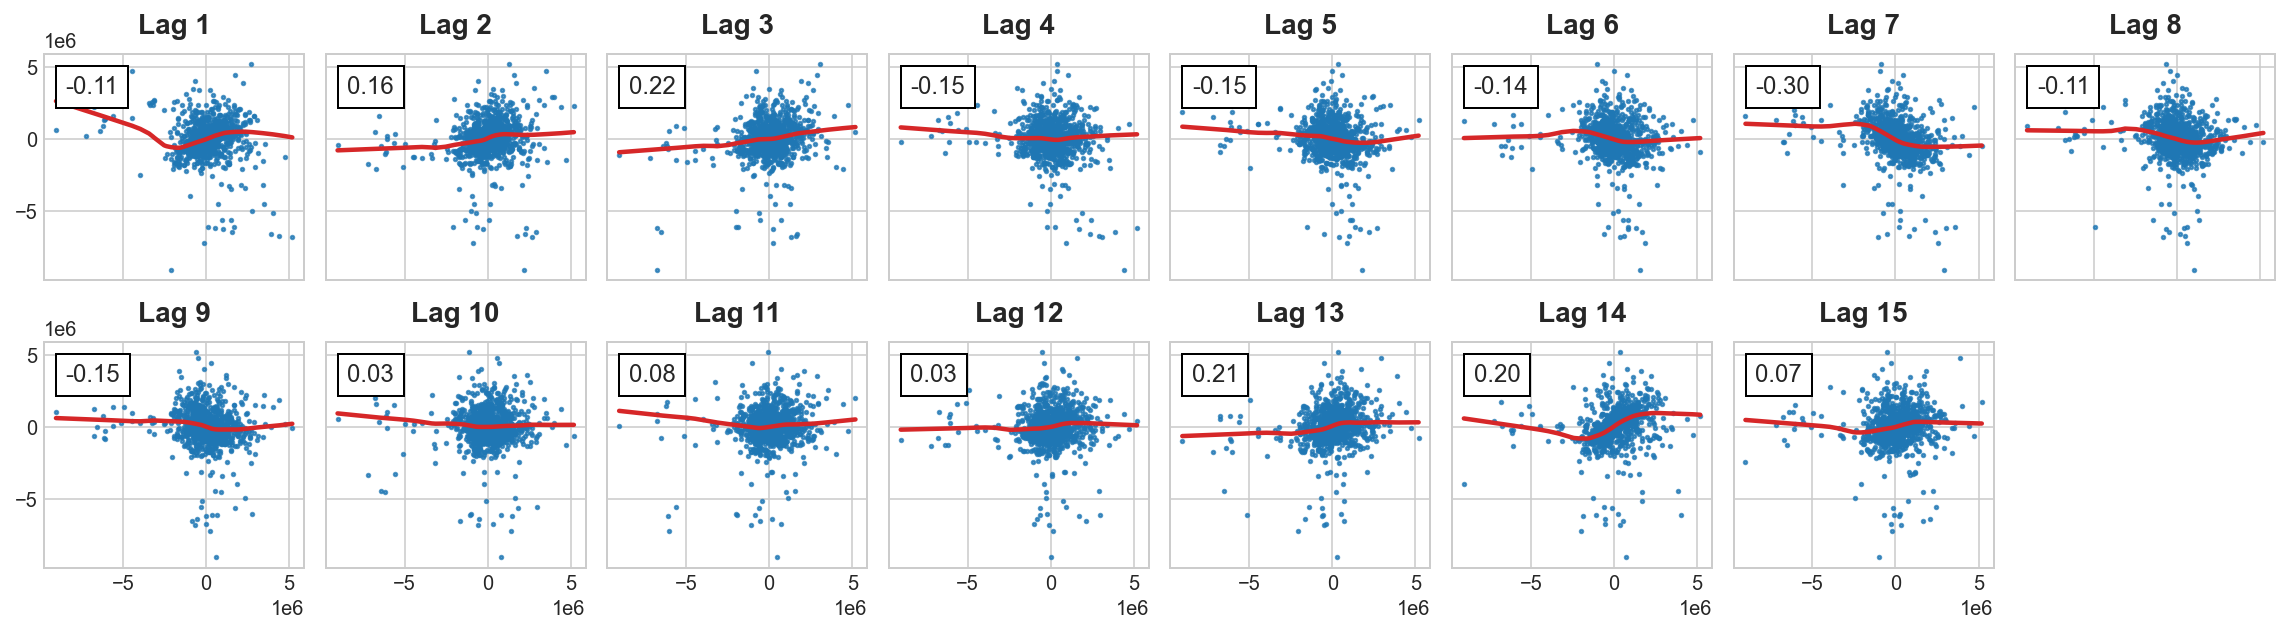

In [77]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_deseason, lags=15);
plot_lags(y_deseason, lags=15, nrows=2);

As seen above on the `'Partial Autocorrelation'` chart, several lag variables are statistically significant so we can say that there is a cyclic behavious in the series.\
The partial autocorrelations suggest that the dependence can be captured using the first seven lags.

# 6 - Forecasting

Preparing target series for multistep forecasting.

It will be beneficial to fint the leading indicators to improve the forecast. A leading indicator would be the state holidays, since the vast majority of the shops are closed during a holday, people tend to do their shopping just befor or after these holidays which would create shocks in our series.\
`'promotions'` dates are also useful and they don't cause data leakage since the firm decides those dates.

## 6.1 - Creating the multistep dataset and plot

In [79]:
# Functions for multistep dataset creation
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [80]:
y = total_sales["Sales"]  # the target, as in the section 3.1.2

X = make_lags(y, lags=7).dropna()

y = make_multistep_target(y, steps=31).dropna()

y, X = y.align(X, join='inner', axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False) # 'shuffle=False' since this is a time series, it is better to train data in blocks.

## 6.2 - Using Direct strategy by instantiating a model

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

## 6.3 - Using DirRec strategy by instantiating a model

In [84]:
# Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train LR RMSE: {train_rmse:.2f}\n" f"Test LR RMSE: {test_rmse:.2f}"))

# XGBRegressor
from sklearn.multioutput import RegressorChain

model = RegressorChain(base_estimator = XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train XGB RMSE: {train_rmse:.2f}\n" f"Test XGB RMSE: {test_rmse:.2f}"))

Train LR RMSE: 2161706.33
Test LR RMSE: 2471036.09
Train XGB RMSE: 1084758.72
Test XGB RMSE: 2354117.11


In terms of training set we can say that XGBoost is overfitting on the training set.\
Contrary to that XGBoost performs better than linear regression on the test set.\
With some hyperparameter tuning we would obtain better scores on XGBoost.

Another application would be hybrid modelling to benefit from both of the models.

**TODO!!**: 
- Apply Cross Validation
- Apply hybrid modelling
- Try more models